# Renta de Bicicletas

## Prediccion de la demanda en el alquiler de bicicletas

**librerias**

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from math import sqrt
import pickle

import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.linear_model import LinearRegression as LinReg
from sklearn.preprocessing import PolynomialFeatures as PF
from sklearn.ensemble import GradientBoostingRegressor as GBR


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

## Datos

UCI's Bike Sharing Dataset Data Set
[link](https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset)

<B>Resumen:</B> Este dataset contiene las rentas de bicicletas por hora y dia entre los años 2011 y 2012 en el sistema Capital Bikeshare con la correspondiente informacion climatologica y estacional.

**Atributos:**


Ambos csv tienen los siguientes campos, excepto hr que no esta en day.csv

- **instant**: indice
- **dteday** : fecha
- **season** : estacion (1:primavera, 2:verano, 3:otoño, 4:invierno)
- **yr** : año (0: 2011, 1:2012)
- **mnth** : mes ( 1 to 12)
- **hr** : hora (0 to 23)
- **holiday** : dia festivo o no
- **weekday** : dia de la semana
- **workingday** : dia laborable o no
+ **weathersit** : 
    - 1: Despejado, Pocas nubes, Parcialmente nublado
    - 2: Niebla, Niebla+Nublado
    - 3: Nieve ligera, LLuvia ligera+Tormenta+Nube dispersa
    - 4: LLuvia fuerte+Hielo+Tormenta+Niebla,Nieve+Niebla
- **temp** : temperatura normalizada en grados centigrados. MinMax Scaler (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (solo en escala horaria)
- **atemp**: sensacion termica normalizada en grados centigrados. MinMax Scaler (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (solo en escala horaria)
- **hum**: humedad normalizada, dividido entre 100 (max)
- **windspeed**: velocidad del viento normalizada, dividido entre 67 (max)
- **casual**: cuenta de usuarios casuales
- **registered**: cuenta de usuarios registrados
- **cnt**: cuenta total del alquiler de bicicletas, incluyendo tanto los casuales como los registrados



In [2]:
hour_df=pd.read_csv('data/hour.csv')  # datos por hora
day_df=pd.read_csv('data/day.csv')    # datos por dia

hour_df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [3]:
day_df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


**nos centraremos en los datos por hora**

In [5]:
# primero se quitan dos columnas con info redundante...

hour_df=hour_df.drop(columns=['casual', 'registered'])

In [6]:
# info del dataframe, no hay nulos

hour_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 15 columns):
instant       17379 non-null int64
dteday        17379 non-null object
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weathersit    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
cnt           17379 non-null int64
dtypes: float64(4), int64(10), object(1)
memory usage: 3.0 MB


In [7]:
# downcasting

for e in hour_df.select_dtypes('integer').columns:
    hour_df[e]=pd.to_numeric(hour_df[e], downcast='integer')

for e in hour_df.select_dtypes('float').columns:
    hour_df[e]=pd.to_numeric(hour_df[e], downcast='float')


hour_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 15 columns):
instant       17379 non-null int16
dteday        17379 non-null object
season        17379 non-null int8
yr            17379 non-null int8
mnth          17379 non-null int8
hr            17379 non-null int8
holiday       17379 non-null int8
weekday       17379 non-null int8
workingday    17379 non-null int8
weathersit    17379 non-null int8
temp          17379 non-null float32
atemp         17379 non-null float32
hum           17379 non-null float32
windspeed     17379 non-null float32
cnt           17379 non-null int16
dtypes: float32(4), int16(2), int8(8), object(1)
memory usage: 1.6 MB


In [8]:
# descripcion

hour_df.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,977.000000


In [10]:
# objetivo - cnt (cuenta)

hour_df.cnt.describe()

count    17379.000000
mean       189.463088
std        181.387599
min          1.000000
25%         40.000000
50%        142.000000
75%        281.000000
max        977.000000
Name: cnt, dtype: float64

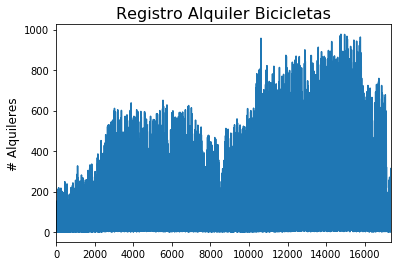

In [24]:
hour_df.cnt.plot()
plt.ylabel('# Alquileres', fontsize=12)
plt.title('Registro Alquiler Bicicletas', fontsize=16)
plt.show();

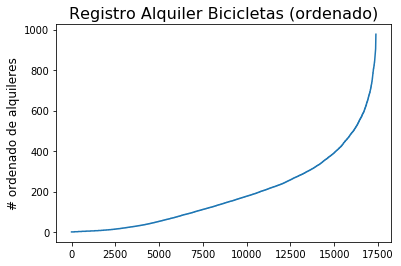

In [26]:
plt.plot(sorted(hour_df.cnt))
plt.ylabel('# ordenado de alquileres', fontsize=12)
plt.title('Registro Alquiler Bicicletas (ordenado)', fontsize=16)
plt.show();

**comparacion del objetivo con la variables numericas**

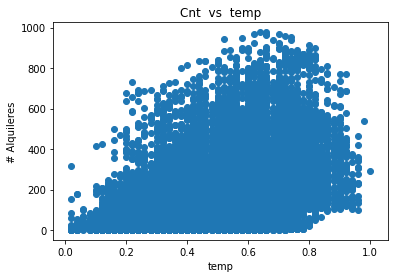

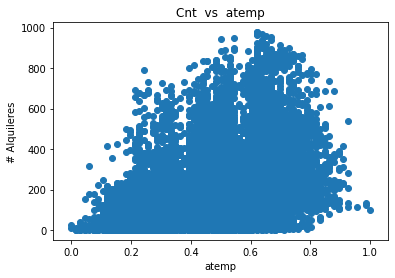

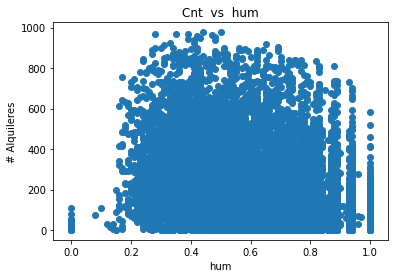

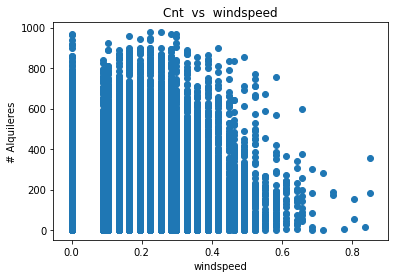

In [31]:
# cuenta contra temperatura, sensacion termica, humedad y velocidad del viento

count=0


for t in hour_df.dtypes:
    
    if (t=='float32'):
        hour_df=hour_df.sort_values(hour_df.dtypes.index[count])
        feat=hour_df.dtypes.index[count]
        
        plt.scatter(hour_df[feat], hour_df.cnt)
        plt.title('Cnt  vs  ' + feat)
        plt.xlabel(feat)
        plt.ylabel('# Alquileres')
        plt.show();
        
    count+=1

**comparacion del objetivo con la variables categoricas**

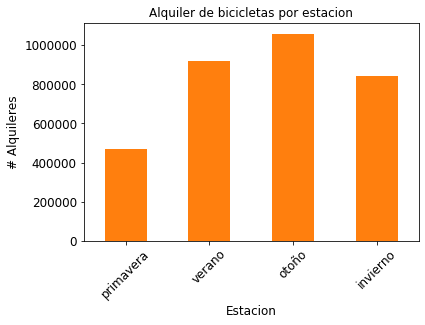

In [38]:
# por estacion del año

df1=hour_df[['season','cnt']].groupby(['season']).sum().reset_index()

df1.plot(kind='bar', legend=False, 
         title ='Alquiler de bicicletas por estacion', 
         stacked=True, 
         fontsize=12)

plt.xlabel('Estacion', fontsize=12)
plt.ylabel('# Alquileres', fontsize=12)
plt.xticks(range(4), 
           ['primavera','verano','otoño','invierno'], 
           rotation=45)
plt.show();

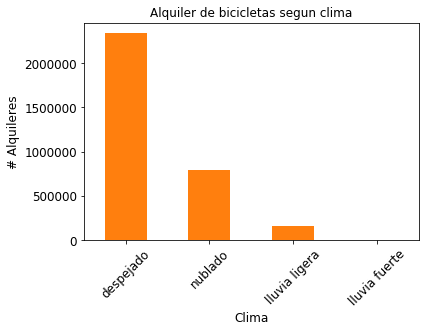

In [39]:
# segun clima

df2=hour_df[['weathersit','cnt']].groupby(['weathersit']).sum().reset_index()

df2.plot(kind='bar', legend=False, 
         title ='Alquiler de bicicletas segun clima', 
         stacked=True, 
         fontsize=12)

plt.xlabel('Clima', fontsize=12)
plt.ylabel('# Alquileres', fontsize=12)
plt.xticks(range(4), 
           ['despejado','nublado','lluvia ligera','lluvia fuerte'], 
           rotation=45)
plt.show();

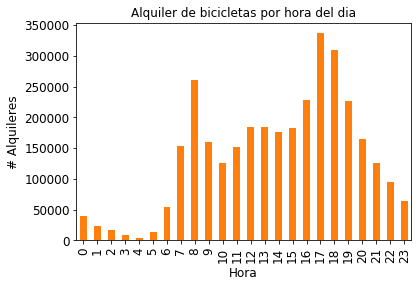

In [45]:
# por horas

df3=hour_df[['hr','cnt']].groupby(['hr']).sum().reset_index()

df3.plot(kind='bar', legend=False, 
         title ='Alquiler de bicicletas por hora del dia', 
         stacked=True, 
         fontsize=12)

plt.xlabel('Hora', fontsize=12)
plt.ylabel('# Alquileres', fontsize=12)
plt.show();

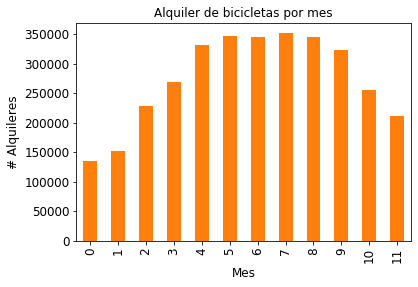

In [46]:
# por mes

df3=hour_df[['mnth','cnt']].groupby(['mnth']).sum().reset_index()

df3.plot(kind='bar', legend=False, 
         title ='Alquiler de bicicletas por mes', 
         stacked=True, 
         fontsize=12)

plt.xlabel('Mes', fontsize=12)
plt.ylabel('# Alquileres', fontsize=12)
plt.show();